In [48]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util import subject
from util.path import Path
from constants import CONVS_STRANGERS

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


# num of turns per convo

In [3]:
def reduce_consecutive(df: pd.DataFrame, on: str) -> pd.DataFrame:
    newdf = df.copy()
    newdf['key'] = (df[on] != df[on].shift(1)).astype(int).cumsum()
    newdf = newdf.groupby('key').first()  # NOTE hardcoded function
    newdf.reset_index(drop=True, inplace=True)
    return newdf

In [17]:
transpath = Path(root="stimuli", datatype="transcript", suffix="utterance", ext=".csv")
files = glob(transpath.starstr(["conv", "datatype"]))
print(len(files))

dfs = []
for filename in files:
    filepath = Path.frompath(filename)
    if filepath['conv'] in CONVS_STRANGERS:
        df = pd.read_csv(filename)
        df.insert(0, "trial", filepath["trial"])
        df.insert(0, "run", filepath["run"])
        df.insert(0, "conv", filepath["conv"])

        df['durr'] = df.onset.diff(periods=-1)
        df.iloc[-1, -1] = df.iloc[-1, 4] - 180
        df['durr'] = -1 * df['durr']

        dfs.append(df)

df = pd.concat(dfs)
df.sort_values(["conv", "run", "trial", "onset"], inplace=True)
df.reset_index(drop=True, inplace=True)

df['textlen'] = df.text.apply(len)

print(len(df))
df.head()

590
1816


,conv,run,trial,speaker,onset,text,durr,textlen
0,104,1,1,4,3,"Um, I would not want to be famous in any capac...",23.0,224
1,104,1,1,104,26,"Yeah, I think it's kind of bizarre, uh, in lik...",29.0,340
2,104,1,1,4,55,I agree. I think that you also give up a lot o...,28.0,317
3,104,1,1,104,83,"Yeah, when you look at the examples like, Prin...",34.0,509
4,104,1,1,4,117,"Um...actually couldn't hear you that well, but...",30.0,356


In [25]:
# get total text length per trial
dfl = df.groupby(['conv', 'run', 'trial'])[['textlen', 'durr']].sum()
dfl

textlen   durr
conv run trial                
104  1   1         2215  177.0
         4         2607  179.0
     2   6         2435  178.0
         7         2631  178.0
     3   10        2540  179.0
...                 ...    ...
174  3   12        2465  178.0
     4   13        2678  180.0
         15        2456  180.0
     5   18        2583  179.0
         20        2554  180.0

[290 rows x 2 columns]

In [23]:
# get number of turns per trial
df2 = reduce_consecutive(df, on='speaker')
dfc = df2.groupby(['conv', 'run', 'trial']).speaker.count()
dfc

conv  run  trial
104   1    1        6
           4        4
      2    6        9
           7        6
      3    10       6
                   ..
174   3    12       2
      4    13       2
           15       2
      5    18       2
           20       2
Name: speaker, Length: 290, dtype: int64

In [31]:
dfl.sort_values('textlen')

,,,textlen,durr
conv,run,trial,,
132,4,15,638,171.0
133,5,20,1749,180.0
128,1,1,1806,176.0
158,1,1,1883,178.0
106,1,1,1886,178.0
...,...,...,...,...
117,5,10,3228,180.0
126,2,7,3246,178.0
117,1,3,3248,177.0


In [26]:
# merge those two
df2 = pd.concat((dfl, dfc), axis=1)
df2

textlen   durr  speaker
conv run trial                         
104  1   1         2215  177.0        6
         4         2607  179.0        4
     2   6         2435  178.0        9
         7         2631  178.0        6
     3   10        2540  179.0        6
...                 ...    ...      ...
174  3   12        2465  178.0        2
     4   13        2678  180.0        2
         15        2456  180.0        2
     5   18        2583  179.0        2
         20        2554  180.0        2

[290 rows x 3 columns]

In [33]:
df2.describe()

,textlen,durr,speaker
count,290.000000,290.000000,290.000000
mean,2542.255172,177.972414,4.872414
std,304.249062,1.724823,2.511068
min,638.000000,162.000000,1.000000
25%,2359.500000,177.000000,3.000000
50%,2543.500000,178.000000,4.500000
75%,2734.750000,179.000000,6.000000
max,3330.000000,180.000000,17.000000


<Axes: ylabel='Frequency'>

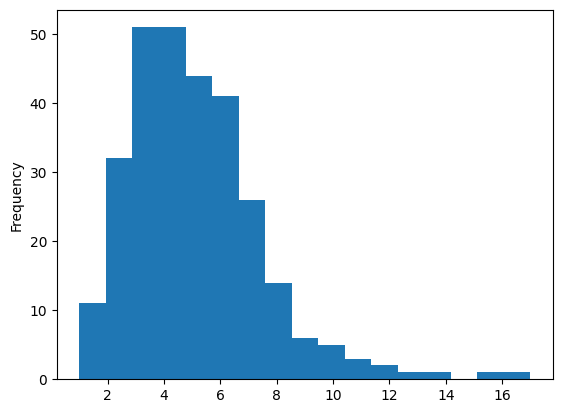

In [37]:
df2.speaker.plot(kind='hist', bins=17)

In [46]:
# does number of turns change over runs/prompts?
df2.groupby('trial').speaker.mean()

trial
1     6.125000
2     5.388889
3     6.125000
4     4.777778
5     6.058824
6     6.928571
7     5.083333
8     4.736842
9     4.727273
10    4.444444
11    3.857143
12    3.866667
13    3.500000
14    4.153846
15    4.769231
16    5.142857
17    3.500000
18    4.214286
19    5.000000
20    3.909091
Name: speaker, dtype: float64

In [45]:
# does they talk more toward the end?
df2.groupby('trial').textlen.mean()

trial
1     2284.750000
2     2537.833333
3     2570.562500
4     2554.277778
5     2503.823529
6     2552.285714
7     2591.250000
8     2572.684211
9     2508.181818
10    2583.611111
11    2658.071429
12    2502.266667
13    2522.785714
14    2602.230769
15    2338.076923
16    2611.142857
17    2681.400000
18    2554.357143
19    2653.692308
20    2511.272727
Name: textlen, dtype: float64

# surprising utterances

do these relate to enjoyment more?
use BERT for next-sentence prediction to check for utterances

In [51]:
modelname = 'model-gpt2-2b_layer-24'

In [52]:
dfs = []
# perplexity = exp( - 1/n sum (log p ))
for sub in CONVS_STRANGERS:
    df = subject.get_transcript(sub, modelname=modelname)
    df["true_prob"] = np.log(df["true_prob"])

    df["trial"] = ((df["trial"] - 1) % 4) + 1
    df.rename(
        columns={
            "speaker": "subject",
            "entropy": "self_entropy",
            "true_prob": "self_logp",
        },
        inplace=True,
    )
    df = df.groupby(["subject", "run", "trial"])[["self_entropy", "self_logp"]].mean()
    df2 = df.reset_index()
    df2.subject = [i + 100 if i < 100 else i - 100 for i in df2.subject.values]
    df2.set_index(["subject", "run", "trial"], inplace=True)
    df2.rename(
        columns={"self_entropy": "other_entropy", "self_logp": "other_logp"},
        inplace=True,
    )
    dfs.append(pd.concat((df, df2), axis=1))
df_llm_metrics = pd.concat(dfs)
df_llm_metrics

self_entropy  self_logp  other_entropy  other_logp
subject run trial                                                    
4       1   1          2.962263 -14.606378       3.062427  -14.431515
            4          2.648575 -14.702961       3.017559  -14.536549
        2   2          2.816953 -14.528123       2.813869  -14.545061
            3          2.647496 -14.657528       2.384253  -13.972854
        3   2          2.657225 -14.678764       2.719792  -13.900380
...                         ...        ...            ...         ...
174     3   4          2.489048 -14.266784       2.707669  -14.004907
        4   1          2.497472 -14.476631       2.901053  -14.246256
            3          2.348667 -14.058031       2.586149  -13.854210
        5   2          2.586714 -14.463260       2.777839  -14.234635
            4          2.714751 -14.199518       2.672705  -14.444757

[580 rows x 4 columns]

In [54]:
dft = subject.get_transcript(sub, modelname=modelname)
dft

,run,trial,word_idx,speaker,sentence,word,start,end,score,hftoken,token_id,rank,true_prob,entropy,embedding
0,1,1,0,74,1,...,NaN,NaN,NaN,Ġ...,2644,5820,2.607732e-06,6.762034,"[2.1977777, 1.153782, 6.408772, -2.2142045, 1...."
1,1,1,1,74,1,whether,0.560,0.820,0.810,Ġwhether,1771,303,8.907950e-08,6.546846,"[-3.3883185, -5.03211, 0.86582553, -6.6242013,..."
2,1,1,2,74,1,I'd,0.860,1.021,0.740,ĠI,314,12,1.727804e-06,4.678407,"[-4.1771216, -4.9492407, -0.21502817, -0.28559..."
3,1,1,2,74,1,I'd,0.860,1.021,0.740,'d,1549,11,5.962659e-07,4.631248,"[-2.2414374, -8.193962, -0.39822453, 1.8527586..."
4,1,1,3,74,1,want,1.061,1.281,0.976,Ġwant,765,5,8.058331e-08,4.663439,"[2.186237, -1.7354745, -1.0670502, 1.3687354, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405,5,20,491,174,2,or,179.292,179.442,0.582,Ġor,393,4,6.504758e-06,2.902752,"[-2.755403, -4.207426, -1.2174932, -0.4429596,..."
6406,5,20,492,174,2,have,179.485,179.635,0.712,Ġhave,423,7,5.969987e-07,3.508187,"[-2.9332025, -4.1492357, 1.0633906, -0.2840307..."
6407,5,20,493,174,2,like,179.678,179.828,0.395,Ġlike,588,6,6.370249e-07,3.575296,"[-3.9342608, 1.8888967, 4.0537734, -2.7615952,..."
6408,5,20,494,174,2,that-,179.871,180.000,0.377,Ġthat,326,23,4.930012e-07,3.288140,"[-1.3314713, 0.09165797, 2.3718574, 0.98375285..."


In [68]:
dft1 = dft.groupby(['run', 'trial', 'speaker', 'sentence'], sort=False).hftoken.apply(lambda x: ' '.join(x))
dft1.head(20)

run  trial  speaker  sentence
1    1      74       1           Ġ... Ġwhether ĠI 'd Ġwant Ġto Ġdo Ġsomeone , Ġ...
                     2           ĠUm , ĠI Ġdon 't Ġknow . ĠIt 's Ġhard Ġto , Ġi...
                     3           ĠI Ġthink ĠI 'd Ġgo Ġwith Ġsomeone , Ġlike , Ġ...
                     4           ĠUm , Ġlike , Ġmaybe , Ġlike , ĠML K Ġor Ġsome...
                     5                                         ĠWhat Ġabout Ġyou ?
            174      1           ĠYeah , ĠI Ġwould Ġdefinitely Ġagree Ġwith Ġth...
                     2           ĠI Ġthink ĠI 'd Ġprobably Ġwant Ġto Ġgo Ġwith ...
                     3           ĠFor Ġme Ġpersonally , Ġlike , ĠI Ġwant Ġit Ġt...
                     4           ĠUm , Ġso , Ġlike , Ġfor Ġme Ġpersonally , ĠI ...
                     5           ĠYeah , ĠI Ġjust ... Ġoverall ĠI 'd Ġsay Ġsome...
     4      174      1           ĠI 'd Ġsay Ġa Ġperfect Ġday Ġfor Ġme Ġwould Ġb...
                     2           ĠI Ġmean , ĠI , ĠI 'm Ġs

In [59]:
dftt = dft.groupby(['run', 'trial', 'speaker', 'sentence']).entropy.mean()
dftt.head(50)

run  trial  speaker  sentence
1    1      74       1           3.135700
                     2           2.229263
                     3           2.616217
                     4           2.741055
                     5           2.238278
            174      1           2.386603
                     2           2.171217
                     3           2.272333
                     4           2.480165
                     5           2.418713
     4      74       1           2.709492
                     2           2.899302
                     3           2.468626
                     4           2.866432
                     5           2.413252
                     6           2.964337
                     7           2.822396
                     8           2.713109
                     9           2.208962
                     10          2.870936
            174      1           2.783698
                     2           3.055177
                     3           2.791310
    